In [2]:
# !pip install pypianoroll

In [2]:
import pypianoroll
import glob
import mido
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def midi_to_pianoroll(files_path):
    piano_roll = []
    for file in glob.glob(files_path):
        track_count = 0
        multitrack = pypianoroll.read(file)
        pianorolls = multitrack.tracks
        multitrack_for_piano_roll = pypianoroll.Multitrack()
        for track in pianorolls:
            if(track.is_drum == False):
                multitrack_for_piano_roll.append(pypianoroll.StandardTrack(pianoroll=track.pianoroll, program=track_count))
                track_count += 1
                
        track_piano_roll = multitrack_for_piano_roll.blend()
        square = [track_piano_roll[i:i+128] for i in range(0, len(track_piano_roll), 128) if len(track_piano_roll[i:i+128]) == 128]

        #Нормализация(изменяем громкость каждой ноты на 1)
        for note in square:
            note[note != 0] = 1
            piano_roll.append(note)

    return piano_roll

In [4]:
def pianoroll_to_midi(piano_rolls, file_path):
    piano_roll = np.concatenate(piano_rolls, axis=0)
    multitrack_out = pypianoroll.Multitrack()
    multitrack_out.append(pypianoroll.StandardTrack(pianoroll=piano_roll, program=0))
    multitrack_out.write(file_path)
    return multitrack_out.tracks[0].pianoroll


## Example

Пример преобразования midi в piano roll с помощью функции midi_to_pianoroll, описанной выше

In [6]:
files_path = "input-data/midi/classical/*.mid"
piano_rolls = midi_to_pianoroll(files_path)

c:\Python311\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Иллюстрация фрагментов piano roll

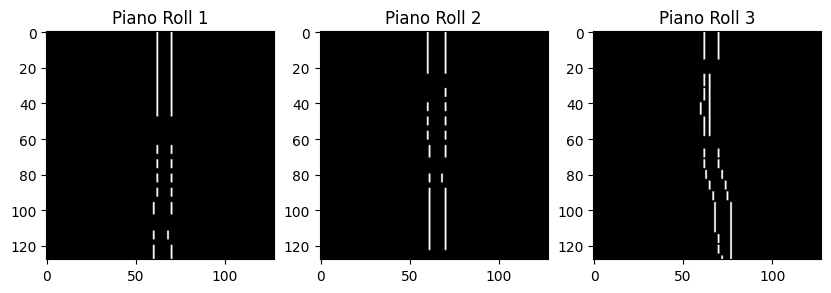

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(piano_rolls[0], cmap="gray")
axs[0].set_title("Piano Roll 1")

axs[1].imshow(piano_rolls[1], cmap="gray")
axs[1].set_title("Piano Roll 2")

axs[2].imshow(piano_rolls[3], cmap="gray")
axs[2].set_title("Piano Roll 3")

plt.show()

Сохранение и загрузка piano_rolls (Будет нужно для обучения и генерации)

In [9]:
np.save('input-data/piano_rolls/classical/piano_rolls.npy', piano_rolls)

## Обратное преобразование сгенерированных piano roll

In [11]:
generated_piano_rolls = np.load('generated/piano_rolls/classical/piano_rolls.npy', allow_pickle=True)
#Делаем громкость максимальной
generated_piano_rolls = generated_piano_rolls*127

In [12]:
midi = pianoroll_to_midi(generated_piano_rolls, "generated/tmp/example_out.mid")

Увеличение темпа (преобразование в piano roll, почти в два раза замедляет midi)

In [13]:
files_path = "generated/tmp/*.mid"
for file, i in zip(glob.glob(files_path), range(len(glob.glob(files_path)))):
    mid = mido.MidiFile(file)

    new_tempo = mido.bpm2tempo(240)
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'set_tempo':
                msg.tempo = new_tempo

    mid.save("generated/tmp/speedup_example_out_" + str(i) + ".mid")
